# Step 2 - Choosing a Model

In this notebook, I have documented how different models are trained and how I determined which of the models achieved the best results.

I trained the following models:
- **neuralnet_model:** A traditional feed-forward neural network for benchmarking against the performance of Convolutional Neural Networks
- **cnn_model:** A convolutional neural network trained from scratch
- **VGG19:** A *pre-trained* convolutional neural network for transfer-learning
- **ResNet50:** A *pre-trained* convolutional neural network for transfer-learning
- **InceptionV3:** A *pre-trained* convolutional neural network for transfer-learning

All 5 models are trained and saved in a list. After training the models, we iterate through the list and determine the models' respective F1 scores with the following formula:
![title](notebook_images/f1_formula.jpg)

We will use the training and validation data to train the models described above. Afterwards, we use the testing set (which the models haven't seen before) to calculate their F1 scores. The model with the highest F1 score on the testing set, is the model we're going to use.

In [2]:
# import dependencies
from image_preprocessor import ImagePreprocessor

import numpy as np
import random
import os
import shutil
from glob import glob

from sklearn.datasets import load_files
from keras.utils import np_utils
from keras.preprocessing import image as Image

from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3

import keras.callbacks as callbacks
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model
from keras.callbacks import TensorBoard

import re
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


## Set parameters

The parameters below are used throughout the rest of the code. They describe where the images are located and how the datasets should be processed.

In [3]:
root_dir = os.path.join('..', 'application', 'images')
originals_dir = os.path.join(root_dir, "original")
training_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "test")
val_dir = os.path.join(root_dir, "validation")

target_imagesize = (256, 256)

clear_existing_data = True # if true, data in training, test and validation directories will be deleted before splitting the data in the originals directory
augment_data = True # whether images should be augmented during preprocessing
augmentations = 20 # how many augmentations to make for each original image

random_seed = 7

epochs = 10
batch_size = 50
saved_models_dir = os.path.join('..', 'application', 'saved_models')

## Instantiate preprocessor and preprocess the dataset

In the code below, we instantiate and run the *Image Preprocessor* class. This class takes the images from the original dataset and splits them into training, validation, and test sets. This is described in more detail in the [Image Preprocessing](Step 1 - Image Preprocessing.ipynb) notebook.

In [4]:
preprocessor = ImagePreprocessor()
preprocessor.root_dir = root_dir
preprocessor.originals_dir = originals_dir
preprocessor.training_dir = training_dir
preprocessor.test_dir = test_dir
preprocessor.val_dir = val_dir
preprocessor.random_seed = random_seed
preprocessor.target_imagesize = target_imagesize
preprocessor.clear_existing_data = clear_existing_data

preprocessor.initialize()
categories = preprocessor.categories
training_count = preprocessor.training_count
validation_count = preprocessor.validation_count
test_count = preprocessor.test_count

6 image categories
465 total images

279 training images
93 validation images
93 test images

Categories:
  - animal
  - city_scape
  - food
  - group
  - landscape
  - me


## Generate augmented images

Because our dataset is relatively small (only a few hundred images), we will artificially generate more data by augmenting the images. The original images are randomly rotated, zoomed and / or flipped horizontally.

![title](notebook_images/image_augmentation.jpg)

In [4]:
img_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255,
    fill_mode='reflect')

train_generator = img_datagen.flow_from_directory(training_dir,
                                                   target_size=target_imagesize,
                                                   batch_size=augmentations,
                                                   shuffle=True,
                                                   seed=random_seed)

validation_generator = img_datagen.flow_from_directory(val_dir,
                                                   target_size=target_imagesize,
                                                   batch_size=augmentations,
                                                   shuffle=True,
                                                   seed=random_seed)

Found 279 images belonging to 6 classes.
Found 93 images belonging to 6 classes.


## Benchmark model: Random guessing

To get a better understanding of how well our models work, we'll first create a model that just randomly guesses the categories and calculate its F1 score.

In [5]:
def random_guesses(count):
    guesses = []
    for i in range(count):
        guesses.append(random.randint(0, len(categories)))
    return guesses

## Calculating the F1 score

To measure how good the model is at predicting the correct category for images, we calculate the model's F1 score. The higher this score, the better the model is performing. In the end, we choose the model that has the highest F1 score on the images in the test set.

In [6]:
def predict_category(img_path, pred_model):
    img_tensor = preprocessor.file_to_tensor(img_path)
    try:
        h = pred_model.predict(img_tensor)
    except:
        img_tensor = img_tensor.reshape(1,x_length)
        h = pred_model.predict(img_tensor)
    return categories[np.argmax(h)]

In [7]:
def f1_score_cal(model=None):
    test_images = np.array(glob(os.path.join(test_dir, "*", "*")))
    y_true = []
    y_pred = []
    for img in test_images:
        y_true.append(categories.index(re.split(r'[\\/]',img)[-2]))
        if model != None:
            pred = predict_category(img, model)
            y_pred.append(categories.index(pred))
        
    if model == None:
        y_pred = random_guesses(len(y_true))
    
    return f1_score(y_true, y_pred, average='weighted')

# Training

We'll store the trained models in a list called *models*, along with another list of the model names so we can refer to them later. After all models are trained, we'll calculate their *f1 scores* and store them in the f1_scores list.

In [8]:
models = []
modelnames = []
f1_scores = []

models.append(None)
modelnames.append("random")

## Benchmark model: Traditional Neural Network

To test the effectiveness of Convolutional Neural Networks, we'll also create a traditional Feed-Forward Neural Network to see how it compares against CNN's.

In [9]:
# load the file locations and their labels 'y'
train_files, y_train = preprocessor.load_dataset(training_dir)
val_files, y_val = preprocessor.load_dataset(val_dir)
test_files, y_test = preprocessor.load_dataset(test_dir)

# load training, validation, and test matrices
x_train = preprocessor.files_to_tensors(train_files)
x_val = preprocessor.files_to_tensors(val_files)
x_test = preprocessor.files_to_tensors(test_files)

# calculate how many pixels are in the images
x_length = 1
for n in x_train.shape[1:]:
    x_length *= n

# reshape the tensors into single dimensions
x_train = x_train.reshape(len(x_train),x_length)
x_val = x_val.reshape(len(x_val),x_length)
x_test = x_test.reshape(len(x_test),x_length)

C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\PIL\Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [10]:
neuralnet_model = Sequential()
neuralnet_model.add(Dense(512, input_dim=x_length, activation='relu'))
neuralnet_model.add(Dense(512, activation='relu'))
neuralnet_model.add(Dense(512, activation='relu'))
neuralnet_model.add(Dropout(0.3))
neuralnet_model.add(Dense(len(categories), activation='softmax'))
neuralnet_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               100663808 
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 3078      
Total params: 101,192,198
Trainable params: 101,192,198
Non-trainable params: 0
_________________________________________________________________


In [11]:
neuralnet_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath=os.path.join(saved_models_dir, 'traditional_neuralnet.hdf5'), 
                           verbose=1, save_best_only=True)

neuralnet_model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val),
                    verbose=1,
                    callbacks=[checkpointer])

neuralnet_model.load_weights(filepath=os.path.join(saved_models_dir,'traditional_neuralnet.hdf5'))
models.append(neuralnet_model)
modelnames.append("benchmark")

Train on 279 samples, validate on 93 samples
Epoch 1/10
279/279 [==============================] - 7s - loss: 1.8474 - acc: 0.1828 - val_loss: 1.7130 - val_acc: 0.3441
Epoch 2/10
279/279 [==============================] - 11s - loss: 1.6864 - acc: 0.3262 - val_loss: 1.6550 - val_acc: 0.3011
Epoch 3/10
279/279 [==============================] - 6s - loss: 1.5646 - acc: 0.3656 - val_loss: 1.5995 - val_acc: 0.3763
Epoch 4/10
279/279 [==============================] - 7s - loss: 1.4757 - acc: 0.4695 - val_loss: 1.5428 - val_acc: 0.4086
Epoch 5/10
279/279 [==============================] - 6s - loss: 1.4024 - acc: 0.4982 - val_loss: 1.5039 - val_acc: 0.4086
Epoch 6/10
279/279 [==============================] - 7s - loss: 1.2988 - acc: 0.5484 - val_loss: 1.4653 - val_acc: 0.4086
Epoch 7/10
279/279 [==============================] - 6s - loss: 1.2091 - acc: 0.5627 - val_loss: 1.4532 - val_acc: 0.3548
Epoch 8/10
279/279 [==============================] - 0s - loss: 1.1896 - acc: 0.5842 - val_l

## Construct a new CNN model from scratch

In the code below, we'll create a new Convolutional Neural Network from scratch. 

In [12]:
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=16,
                     kernel_size=2, 
                     strides=(1, 1), 
                     padding='same', 
                     activation='relu', 
                     input_shape=(target_imagesize[0], target_imagesize[1], 3)))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=2))
cnn_model.add(Dropout(0.3))
cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.3))
cnn_model.add(Dense(len(categories), activation='softmax'))

cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       32896     
__________

# Train the CNN model

In [13]:
checkpointer = ModelCheckpoint(filepath=os.path.join(saved_models_dir,'cnn_from_scratch.hdf5'), 
                           verbose=1, save_best_only=True)

cnn_model.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
cnn_model.fit_generator(train_generator,
                        steps_per_epoch=training_count, 
                        epochs=epochs,
                        validation_data = validation_generator,
                        validation_steps=validation_count,
                        callbacks=[checkpointer],
                        verbose=1)

cnn_model.load_weights(filepath=os.path.join(saved_models_dir,'cnn_from_scratch.hdf5'))
models.append(cnn_model)
modelnames.append("new cnn")

Epoch 1/10
278/279 [============================>.] - ETA: 0s - loss: 1.7636 - acc: 0.2271

C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\PIL\Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 00000: val_loss improved from inf to 1.73376, saving model to saved_models\cnn_from_scratch.hdf5
279/279 [==============================] - 362s - loss: 1.7635 - acc: 0.2275 - val_loss: 1.7338 - val_acc: 0.2670
Epoch 2/10
279/279 [==============================] - 351s - loss: 1.7190 - acc: 0.2861 - val_loss: 1.7059 - val_acc: 0.3532
Epoch 3/10
279/279 [==============================] - 350s - loss: 1.6932 - acc: 0.3201 - val_loss: 1.6763 - val_acc: 0.3677
Epoch 4/10
279/279 [==============================] - 348s - loss: 1.6510 - acc: 0.3512 - val_loss: 1.6247 - val_acc: 0.3770
Epoch 5/10
279/279 [==============================] - 355s - loss: 1.5868 - acc: 0.3876 - val_loss: 1.5354 - val_acc: 0.4204
Epoch 6/10
279/279 [==============================] - 365s - loss: 1.4917 - acc: 0.4207 - val_loss: 1.4436 - val_acc: 0.4083
Epoch 7/10
279/279 [==============================] - 364s - loss: 1.4156 - acc: 0.4336 - val_loss: 1.3926 - val_acc: 0.4395
Epoch 8/10
279/279 [=============

## Transfer learning

Transfer learning is taking an existing, pre trained model and stripping off the final layer and replacing it with our own layers so it can classify the objects we're looking for. We'll use three different pre-trained networks to see how they compare:
- VGG19
- ResNet50
- InceptionV3

In [14]:
base_models = []
base_models.append(VGG19(include_top=False, weights = 'imagenet', input_shape = (target_imagesize[0], target_imagesize[1], 3)))
base_models.append(ResNet50(include_top=False, weights = 'imagenet', input_shape = (target_imagesize[0], target_imagesize[1], 3)))
base_models.append(InceptionV3(include_top=False, weights = 'imagenet', input_shape = (target_imagesize[0], target_imagesize[1], 3)))

base_modelnames = "VGG19 ResNet50 InceptionV3".split()


## Train pre-trained models

In [15]:
# Train the models
for i, model in enumerate(base_models):
    print("")
    print("Training Model: %s" % base_modelnames[i])
    
    checkpointer = ModelCheckpoint(filepath=os.path.join(saved_models_dir, base_modelnames[i] + '.hdf5'), 
                           verbose=1, save_best_only=True)
    
    for layer in model.layers:
        layer.trainable = False
        
    # custom Layers 
    cus_layers = model.output
    cus_layers = Flatten()(cus_layers)
    cus_layers = Dense(1024, activation="relu")(cus_layers)
    cus_layers = Dropout(0.3)(cus_layers)
    cus_layers = Dense(512, activation="relu")(cus_layers)
    cus_layers = Dropout(0.3)(cus_layers)
    cus_layers = Dense(len(categories), activation="relu")(cus_layers)
    predictions = Dense(len(categories), activation="softmax")(cus_layers)
    
    # create the final model 
    model_final = Model(inputs = model.input, outputs = predictions)

    # compile the model 
    model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=['accuracy'])
    
    # train the model
    model_final.fit_generator(train_generator,
                             steps_per_epoch=training_count // 10, 
                              epochs=epochs,
                             validation_data = validation_generator,
                             validation_steps=validation_count // 10,
                             callbacks=[checkpointer],
                             verbose=1)
    
    model_final.load_weights(filepath=os.path.join(saved_models_dir, base_modelnames[i] + '.hdf5'))
    
    models.append(model_final)
    modelnames.append(base_modelnames[i])


Training Model: VGG19
Epoch 1/10
26/27 [===========================>..] - ETA: 0s - loss: 1.8404 - acc: 0.2176

C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\PIL\Image.py:916: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


Epoch 00000: val_loss improved from inf to 1.79143, saving model to saved_models\VGG19.hdf5
27/27 [==============================] - 39s - loss: 1.8390 - acc: 0.2170 - val_loss: 1.7914 - val_acc: 0.2312
Epoch 2/10
27/27 [==============================] - 28s - loss: 1.7931 - acc: 0.2378 - val_loss: 1.7909 - val_acc: 0.2486
Epoch 3/10
27/27 [==============================] - 29s - loss: 1.7910 - acc: 0.2524 - val_loss: 1.7903 - val_acc: 0.2659
Epoch 4/10
27/27 [==============================] - 29s - loss: 1.7935 - acc: 0.2266 - val_loss: 1.7899 - val_acc: 0.2601
Epoch 5/10
27/27 [==============================] - 28s - loss: 1.7913 - acc: 0.2551 - val_loss: 1.7898 - val_acc: 0.2370
Epoch 6/10
27/27 [==============================] - 28s - loss: 1.7910 - acc: 0.2602 - val_loss: 1.7890 - val_acc: 0.2543
Epoch 7/10
27/27 [==============================] - 29s - loss: 1.7902 - acc: 0.2362 - val_loss: 1.7886 - val_acc: 0.2486
Epoch 8/10
27/27 [==============================] - 28s - loss: 1

# Choosing the model

Now that all of our models are trained, we can calculate their F1 scores on the test set. Important is that none of the models have seen data from the test set during the training phase, so it will be a good indication of how the model will perform in a real-world scenario.

In [16]:
y_pred = []
# load the file locations and their labels 'y'
test_files, y_test = preprocessor.load_dataset(test_dir)

# load training, validation, and test matrices
x_test = preprocessor.files_to_tensors(test_files)

In [17]:
for i, model in enumerate(models):
    f1score = f1_score_cal(model)
    f1_scores.append(f1score)
    print(modelnames[i], f1score)

C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


random 0.164256772637
benchmark 0.457219005606
new cnn 0.521292327744


C:\Users\donke\Anaconda2\envs\cnn_image_classification\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


VGG19 0.098071931776
ResNet50 0.050508039854
InceptionV3 0.735185728948


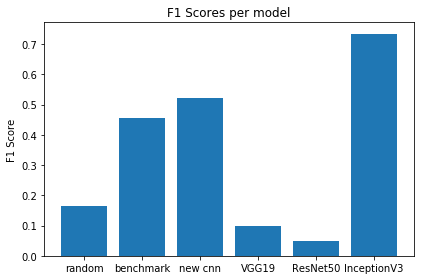

In [18]:
fig, ax = plt.subplots()

index = np.arange(6)

rects1 = ax.bar(index, f1_scores)

ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores per model')
ax.set_xticks(index)
ax.set_xticklabels(modelnames)

fig.tight_layout()
plt.show()

# Conclusion

Knowing that a higher F1 score is better, we can see that the **InceptionV3** model is outperforming all the other models with an F1 score of **0.74**. We'll take the InceptionV3 model and fine-tune as described in the [Fine-tuning the Model](Step 3 - Fine-tuning the Model.ipynb) notebook.